*This notebook provides an example on how to create a SeisBench dataset from an xls event catalog and a folder with mseed files*


In [1]:
import seisbench
import seisbench.data as sbd
import seisbench.util as sbu
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import obspy
import os
from pathlib import Path



# Creating a dataset



##### The catalog has a custom format with the following properties: 
###### 'Datetime', 'X', 'Y', 'Depth', 'Mw', 'Phases', 'mseed_name'
###### Phases is a string with detected phases seperated by comma: <Phase> <Station> <Datetime> e.g. "Pg BRDW 2020-01-01 10:09:44.400, Sg BRDW 2020-01-01 10:09:45.696"

In [2]:
input_path = str(Path.cwd().parent) + "/datasets/igf/"
catalog =  pd.read_excel(input_path + "Catalog_20_21.xlsx", index_col=0)
catalog.head(1)

Datetime             X             Y  Depth        Mw  \
0 2020-01-01 10:09:42.200  5.582503e+06  5.702646e+06    0.7  2.469231   

                                              Phases            mseed_name  
0  Pg BRDW 2020-01-01 10:09:44.400, Sg BRDW 2020-...  20200101100941.mseed

In [4]:
catalog.Phases[0]

'Pg BRDW 2020-01-01 10:09:44.400, Sg BRDW 2020-01-01 10:09:45.696, Pg GROD 2020-01-01 10:09:45.206, Sg GROD 2020-01-01 10:09:46.655, Pg GUZI 2020-01-01 10:09:45.116, Sg GUZI 2020-01-01 10:09:46.561, Pg JEDR 2020-01-01 10:09:44.920, Sg JEDR 2020-01-01 10:09:46.285, Pg MOSK2 2020-01-01 10:09:45.417, Sg MOSK2 2020-01-01 10:09:46.921, Pg NWLU 2020-01-01 10:09:45.686, Sg NWLU 2020-01-01 10:09:47.175, Pg PCHB 2020-01-01 10:09:45.213, Sg PCHB 2020-01-01 10:09:46.565, Pg PPOL 2020-01-01 10:09:44.755, Sg PPOL 2020-01-01 10:09:46.069, Pg RUDN 2020-01-01 10:09:44.502, Sg RUDN 2020-01-01 10:09:45.756, Pg RYNR 2020-01-01 10:09:43.442, Sg RYNR 2020-01-01 10:09:44.394, Pg RZEC 2020-01-01 10:09:46.075, Sg RZEC 2020-01-01 10:09:47.587, Pg SGOR 2020-01-01 10:09:45.817, Sg SGOR 2020-01-01 10:09:47.284, Pg TRBC2 2020-01-01 10:09:44.833, Sg TRBC2 2020-01-01 10:09:46.095, Pg TRN2 2020-01-01 10:09:44.488, Sg TRN2 2020-01-01 10:09:45.698, Pg TRZS 2020-01-01 10:09:46.232, Sg TRZS 2020-01-01 10:09:47.727, Pg ZM

#### SeisBench dataset format 

A dataset consists of 2 components: 
* a metadata file, called `metadata.csv`, with properties of assosiated waveforms
* a waveforms file, called `waveforms.hdf5`, containing the raw waveforms


A dataset is created with `WaveformDataWriter` provided by SeisBench

### Define train/val/test split

Strategy: 
Assign chronologically 70% picks to train, 15% to val, 15% to test sets. 
(Note: Counting picks based on `Phases` column in the `Catalog_20_21.xlsx` produces sets with slightly different proportion as not all traces are available.)

<Axes: xlabel='Datetime'>

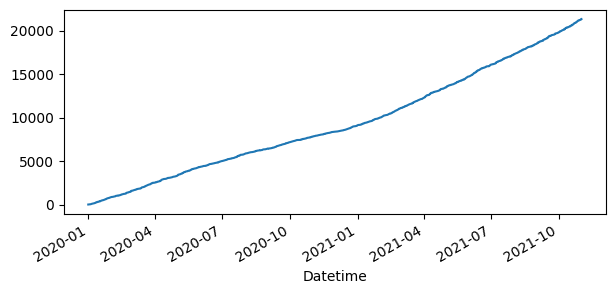

In [3]:
catalog['pick_count'] = catalog.Phases.apply(lambda x: x.count("Pg"))
catalog.index = catalog.Datetime
catalog = catalog.sort_index()
catalog['pick_count_cumsum'] = catalog.pick_count.cumsum()
catalog.pick_count_cumsum.plot(figsize=(7,3))

In [4]:
train_th = 0.7 * catalog.pick_count_cumsum[-1]
dev_th = 0.85 * catalog.pick_count_cumsum[-1]

catalog['split'] = 'test'
for i, event in catalog.iterrows(): 
    if event['pick_count_cumsum'] < train_th: 
        catalog.loc[i, 'split'] = 'train' 
    elif event['pick_count_cumsum'] < dev_th: 
        catalog.loc[i, 'split'] = 'dev' 
    else:
        break

In [5]:
catalog[catalog.split == 'train'].pick_count.sum() / catalog.pick_count.sum()

0.6996718237224566

In [6]:
catalog[catalog.split == 'dev'].pick_count.sum() / catalog.pick_count.sum()

0.149929676511955

In [7]:
catalog[catalog.split == 'test'].pick_count.sum() / catalog.pick_count.sum()

0.15039849976558836

In [8]:
def get_event_params(event): 
    event_params = {
        'source_origin_time': event.Datetime, 
        'source_latitude_deg': event.Y, 
        'source_longitude_deg': event.X, 
        'source_depth_km': event.Depth, 
        'source_magnitude': event.Mw, 
        'split': event.split
    }
    return event_params

def get_event_picks(event): 
    
    picks = [ann.split(' ') for ann in event.Phases.split(', ')]
    picks = pd.DataFrame(picks, columns = ['pick', 'station', 'date', 'hour'])
    picks.index = pd.DatetimeIndex(picks.date + ' ' + picks.hour, tz= "UTC")

    return picks

def get_mseed(fname):
    return obspy.read(fname)


def get_trace_params(trace): 
    trace_params = {
        "station_network_code": trace.stats.network,
        "station_code": trace.stats.station,
        "trace_channel": trace.stats.channel
    }
    return trace_params
    
def get_waves_timestamps(station, phases_string): 
    
    p_ts = None
    s_ts = None

    return p_ts, s_ts
    

In [9]:
output_path = input_path + "seisbench_format/"
metadata_path = output_path + "metadata.csv"
waveforms_path = output_path + "waveforms.hdf5"
train = 0.7
dev = 0.15
test = 0.15

In [10]:
with sbd.WaveformDataWriter(metadata_path, waveforms_path) as writer:

    # Define data format
    writer.data_format = {
        "dimension_order": "CW",
        "component_order": "ZNE",
    }
    
    for event in catalog.itertuples():
        # if "2020-03-03 05:04:43" not in str(event.Datetime): 
        #     continue
        event_params = get_event_params(event)
        event_picks = get_event_picks(event)
        if pd.isna(event.mseed_name): 
            continue
        if os.path.exists(input_path + "mseeds/mseeds_2020/" + event.mseed_name):
            mseed_path = input_path + "mseeds/mseeds_2020/" + event.mseed_name 
        elif os.path.exists(input_path + "mseeds/mseeds_2021/" + event.mseed_name):
            mseed_path = input_path + "mseeds/mseeds_2021/" + event.mseed_name 
        else: 
            continue
        
        
        stream = get_mseed(mseed_path)
        
        for pick_time, pick in event_picks.iterrows():
            waveforms = stream.select(station=pick.station)
            if len(waveforms) == 0:
                # No waveform data available
                continue
        
            trace_params = get_trace_params(waveforms[0])
        
            sampling_rate = waveforms[0].stats.sampling_rate
            # Check that the traces have the same sampling rate
            assert all(trace.stats.sampling_rate == sampling_rate for trace in waveforms)
            
            actual_t_start, data, _ = sbu.stream_to_array(
                waveforms,
                component_order=writer.data_format["component_order"],
            )
            
            trace_params["trace_sampling_rate_hz"] = sampling_rate
            trace_params["trace_start_time"] = str(actual_t_start)

            pick_time = obspy.core.utcdatetime.UTCDateTime(pick_time)
            pick_idx = (pick_time - actual_t_start) * sampling_rate

            trace_params[f"trace_{pick.pick}_arrival_sample"] = int(pick_idx)
            # sample = (pick.time - actual_t_start) * sampling_rate
            # trace_params[f"trace_{pick.phase_hint}_arrival_sample"] = int(sample)
            # trace_params[f"trace_{pick.phase_hint}_status"] = pick.evaluation_mode
            
            writer.add_trace({**event_params, **trace_params}, data)

        # break
            
    

Traces converted: 35784it [01:01, 578.58it/s]


### Load converted dataset

In [11]:
data = sbd.WaveformDataset(output_path, sampling_rate=100)


In [12]:
print(data)

Unnamed dataset - 35784 traces


#### Plot sample

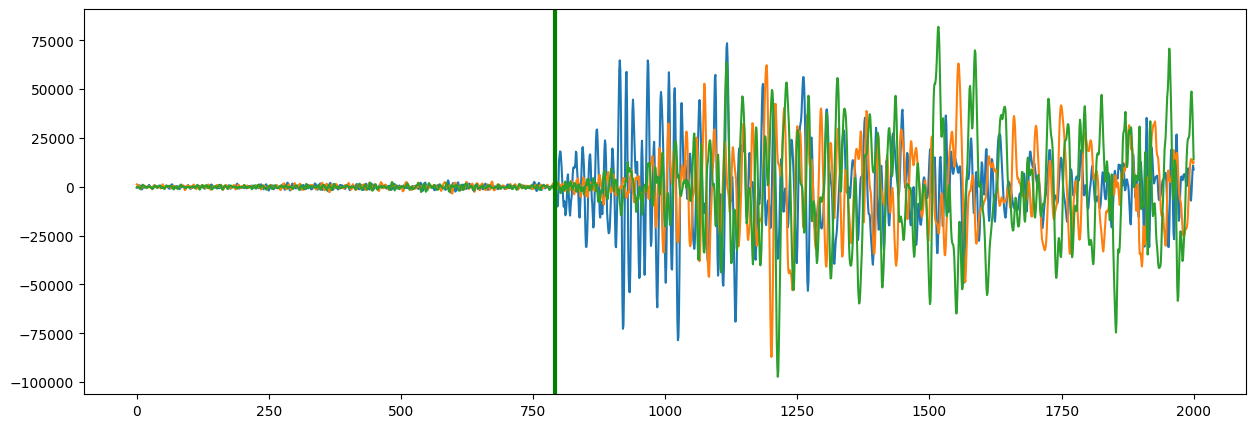

In [13]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.plot(data.get_waveforms(0).T)
ax.axvline(data.metadata["trace_Pg_arrival_sample"].iloc[0], color="green", lw=3)
# ax.axvline(data.metadata["trace_Sg_arrival_sample"].iloc[0], color="black", lw=3)

#### Check train/dev/test proportions

In [14]:
all_samples = len(data.train()) + len(data.dev()) + len(data.test())
print(f"Training examples: {len(data.train())} {len(data.train())/all_samples * 100:.1f}%" )
print(f"Development examples: {len(data.dev())} {len(data.dev())/all_samples * 100:.1f}%")
print(f"Test examples: {len(data.test())} {len(data.test())/all_samples * 100:.1f} %")

Training examples: 24738 69.1%
Development examples: 5508 15.4%
Test examples: 5538 15.5 %


In [15]:
data.metadata.head(5)

index       source_origin_time  source_latitude_deg  source_longitude_deg  \
0      0  2020-01-01 10:09:42.200         5.702646e+06          5.582503e+06   
1      1  2020-01-01 10:09:42.200         5.702646e+06          5.582503e+06   
2      2  2020-01-01 10:09:42.200         5.702646e+06          5.582503e+06   
3      3  2020-01-01 10:09:42.200         5.702646e+06          5.582503e+06   
4      4  2020-01-01 10:09:42.200         5.702646e+06          5.582503e+06   

   source_depth_km  source_magnitude  split station_network_code station_code  \
0              0.7          2.469231  train                   PL         BRDW   
1              0.7          2.469231  train                   PL         BRDW   
2              0.7          2.469231  train                   PL         GROD   
3              0.7          2.469231  train                   PL         GROD   
4              0.7          2.469231  train                   PL         GUZI   

  trace_channel  trace_sampling_rate_hz             trace_start_time  \
0           EHE                   100.0  2020-01-01T10:09:36.480000Z   
1           EHE                   100.0  2020-01-01T10:09:36.480000Z   
2           EHE                   100.0  2020-01-01T10:09:36.480000Z   
3           EHE                   100.0  2020-01-01T10:09:36.480000Z   
4           CNE                   100.0  2020-01-01T10:09:36.476000Z   

   trace_Pg_arrival_sample          trace_name  trace_Sg_arrival_sample  \
0                    792.0  bucket0$0,:3,:2001                      NaN   
1                      NaN  bucket0$1,:3,:2001                    921.0   
2                    872.0  bucket0$2,:3,:2001                      NaN   
3                      NaN  bucket0$3,:3,:2001                   1017.0   
4                    864.0  bucket0$4,:3,:2001                      NaN   

  trace_chunk trace_component_order  
0                               ZNE  
1                               ZNE  
2                               ZNE  
3                               ZNE  
4                               ZNE